# Whiskey clustering 

This example examines 86 Scotch whiskies that have been rated on
a five-point scale for 12 flavor characteristics: Body, sweetness, smoky, medicinal, tobacco, honey, spicy, winey, nutty, malty, fruity, and floral.
This data set comes from a book on the classification of Scotch whisky based on
flavors by David Wishart (2002) and can be found [online](https://www.niss.org/sites/default/files/ScotchWhisky01.txt).

We'll use [Tablesaw](https://jtablesaw.github.io/tablesaw/) to store and manipulate our data
and the clustering and projection classes from the [Smile](http://haifengl.github.io/)
machine learning library. So, we'll add those libraries to the classpath and define some imports to simplify access to the classes we need.

In [1]:
%%classpath add mvn
tech.tablesaw tablesaw-beakerx 0.36.0
com.github.haifengl smile-core 1.5.3
org.knowm.xchart xchart 3.8.3

In [ ]:
%import static tech.tablesaw.aggregate.AggregateFunctions.*
%import tech.tablesaw.api.*
%import tech.tablesaw.columns.*
%import org.knowm.xchart.*
%import smile.clustering.*
%import java.awt.Color
%import smile.feature.extraction.PCA

We'll also enable a BeakerX display widget for Tablesaw tables.

In [ ]:
tech.tablesaw.beakerx.TablesawDisplayer.register()
OutputCell.HIDDEN

### Exploring the data

We start by loading the data and printing its shape and structure.

In [ ]:
records = Table.read().csv("../resources/whiskey.csv")
records.shape()

86 rows X 14 cols

In [ ]:
records.structure()

### K-means clustering

K-means is the most common form of “centroid” clustering. Unlike classification, clustering is an unsupervised learning method. The categories are not predetermined. Instead, the goal is to search for natural groupings in the dataset, such that the members of each group are similar to each other and different from the members of the other groups. The K represents the number of groups to find.

In [ ]:
cols = ["Body", "Sweetness", "Smoky", "Medicinal", "Tobacco", "Honey",
        "Spicy", "Winey", "Nutty", "Malty", "Fruity", "Floral"]
data = records.as().doubleMatrix(*cols)
kMeans = new KMeans(data, 5)

K-Means distortion: 387.52701
Clusters of 86 data points of dimension 12:
  0	   24 (27.9%)
  1	   16 (18.6%)
  2	   23 (26.7%)
  3	    6 ( 7.0%)
  4	   17 (19.8%)


In [ ]:
clusters = Table.create("Clusters", records.stringColumn("Distillery"),
                              DoubleColumn.create("Cluster", kMeans.getClusterLabel()))
clusters = clusters.sortAscendingOn("Cluster", "Distillery")

We have some nice clusters but how do we visualize them? One approach is to use a radar/spider plot.

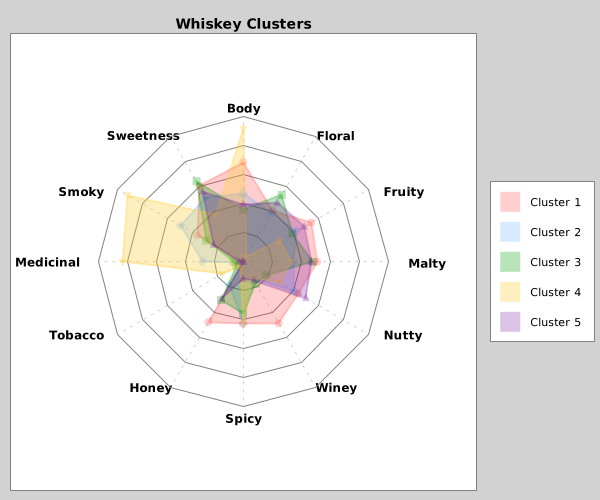

In [ ]:
RadarChart chart = new RadarChartBuilder().width(600).height(500).title('Whiskey Clusters').build()
chart.variableLabels = cols as String[]
chart.styler.with {
    legendVisible = true
    seriesColors = [new Color(255, 51, 51, 60),
                    new Color(51, 153, 255, 50),
                    new Color(0, 153, 0, 70),
                    new Color(255, 204, 51, 80),
                    new Color(102, 0, 153, 60)] as Color[]
}
kMeans.centroids().eachWithIndex { ctrd, num ->
    chart.addSeries("Cluster ${num+1}", ctrd.collect{ it/4 } as double[])
}

BitmapEncoder.getBufferedImage(chart)

Another visualization approach is to reduce our twelve "dimensions" (our features) onto a smaller number of dimensions, typically 2 or 3.

In [ ]:
pca = new PCA(data)
dimensions = 2
numClusters = 5
pca.projection = dimensions
projected = pca.project(data)
clusterer = new KMeans(data, numClusters)
labels = clusterer.clusterLabel.collect { "Cluster " + (it + 1) }
records = records.addColumns(
    *(0..<dimensions).collect { idx ->
        DoubleColumn.create("PCA${idx+1}", (0..<data.size()).collect{
            projected[it][idx]
        })},
    StringColumn.create("Cluster", labels),
    DoubleColumn.create("Centroid", [10] * labels.size())
)
OutputCell.HIDDEN

In [ ]:
colors = [
    'Cluster 1': new Color(255, 31, 31),
    'Cluster 2': new Color(15, 255, 15),
    'Cluster 3': new Color(0, 0, 222),
    'Cluster 4': new Color(255, 255, 32),
    'Cluster 5': new Color(155, 3, 155)
]
title = "Clusters x Principal Components w/ centroids"
plot = new Plot(title: title, xLabel: 'PCA1', yLabel: 'PCA2')
plot << new Points(x: records.column('PCA1').toList(),
                   y: records.column('PCA2').toList(),
                   color: records.column('Cluster').toList().collect{ colors[it] })